In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, ops, random, vmap
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [2]:
sppnames = [
    "afarensis",
    "africanus",
    "habilis",
    "boisei",
    "rudolfensis",
    "ergaster",
    "sapiens",
]
brainvolcc = jnp.array([438, 452, 612, 521, 752, 871, 1350])
masskg = jnp.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})

In [3]:
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()

In [4]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic("mu", a + b * mass_std)
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_1 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m7_1,
    optim.Adam(0.3),
    Trace_ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p7_1 = svi_result.params

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2228.17it/s, init loss: 115.9437, avg. loss [951-1000]: 3.6497]


In [7]:
post = m7_1.sample_posterior(random.PRNGKey(1), p7_1, (2,))
logprob = log_likelihood(m7_1.model, post, d.mass_std.values, d.brain_std.values)
logprob = logprob["brain_std"]
n = logprob.shape[1]
ns = logprob.shape[0]
f = lambda i: logsumexp(logprob[:, i]) - jnp.log(ns)
lppd = vmap(f)(jnp.arange(n))
lppd

DeviceArray([ 0.40866876,  0.4761455 ,  0.54898846,  0.4180616 ,
              0.36465323,  0.39511526, -0.50759256], dtype=float32)

In [9]:
logprob

DeviceArray([[ 0.17073491,  0.24318813,  0.47489464,  0.23943576,
               0.36158043,  0.43194088, -0.45630118],
             [ 0.6007304 ,  0.6649565 ,  0.61796904,  0.5695641 ,
               0.3677166 ,  0.35688156, -0.5616576 ]], dtype=float32)

In [8]:
post

{'a': DeviceArray([0.59417135, 0.5537169 ], dtype=float32),
 'b': DeviceArray([0.09524479, 0.17992333], dtype=float32),
 'log_sigma': DeviceArray([-1.4106632, -1.6210778], dtype=float32),
 'mu': DeviceArray([[0.5199312 , 0.50683004, 0.49809587, 0.5592348 , 0.68151265,
               0.7295504 , 0.66404444],
              [0.41347265, 0.38872367, 0.37222436, 0.4877196 , 0.7187101 ,
               0.8094564 , 0.6857115 ]], dtype=float32)}

In [10]:
m7_1.

In [11]:
p7_1

{'auto_loc': DeviceArray([ 0.5286558 ,  0.16710918, -1.706535  ], dtype=float32)}

# Trying to sample posterior from the model 

To check that models are the same

In [12]:
post = m7_1.sample_posterior(random.PRNGKey(1), p7_1, (1000,))

In [25]:
jnp.mean(post['log_sigma']), jnp.std(post['log_sigma'])

(DeviceArray(-1.7019308, dtype=float32),
 DeviceArray(0.29791224, dtype=float32))

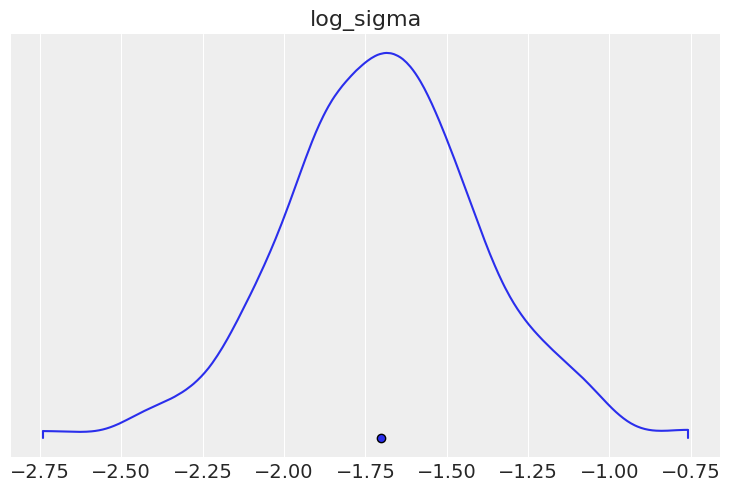

In [26]:
az.plot_density({"log_sigma": post['log_sigma']}, hdi_prob=1)
plt.show()

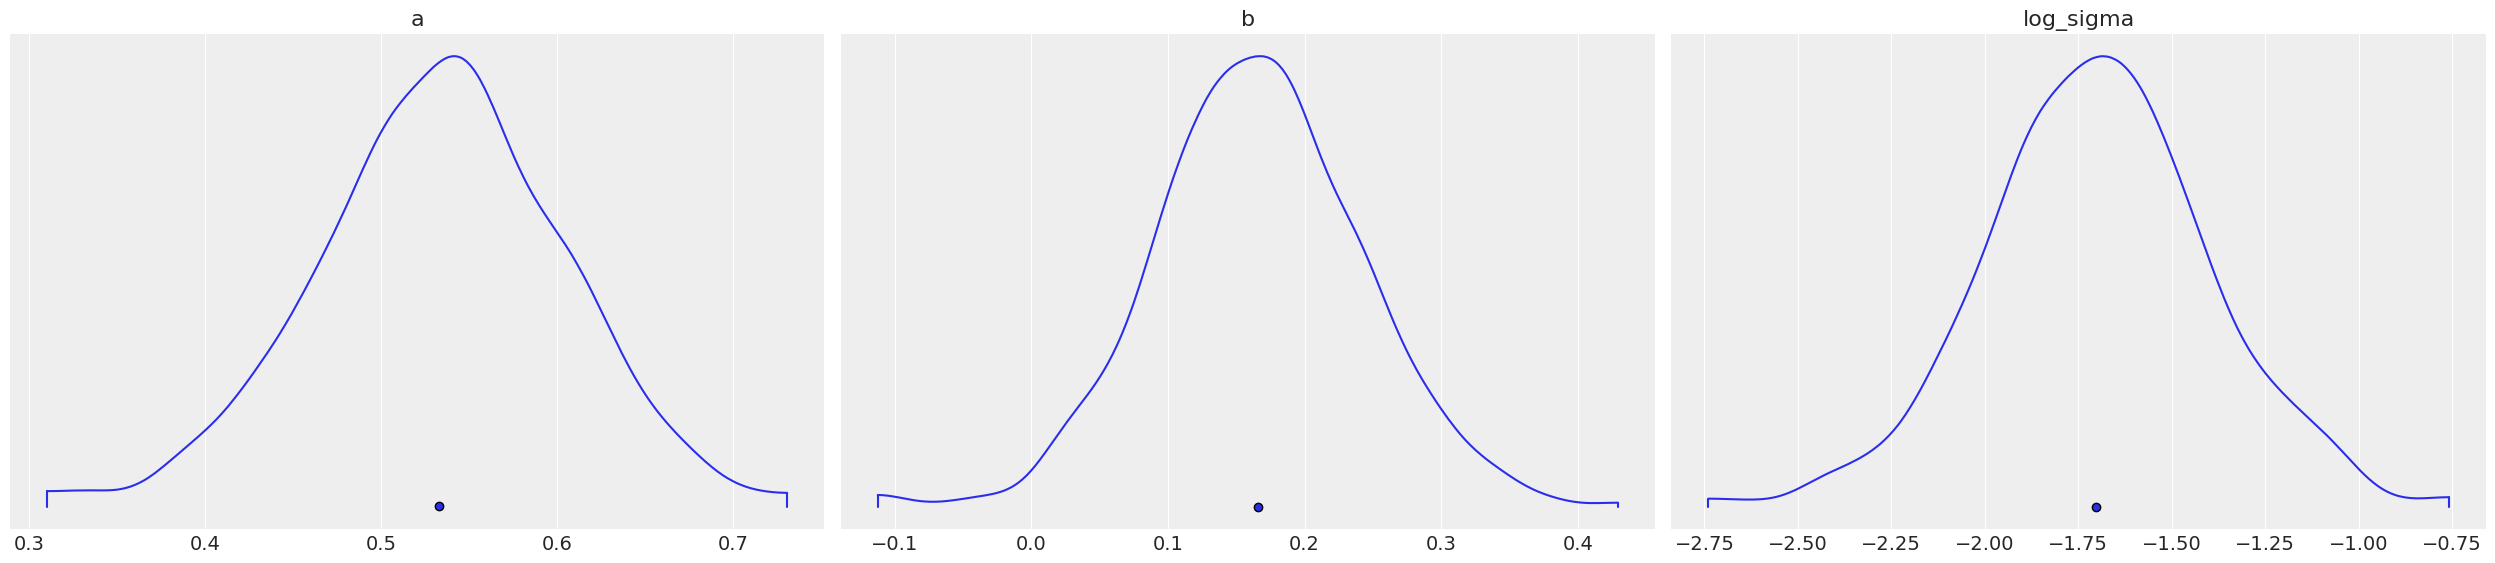

In [17]:
az.plot_density({"a": post['a'], "b": post['b'], "log_sigma": post['log_sigma']}, hdi_prob=1)
plt.show()

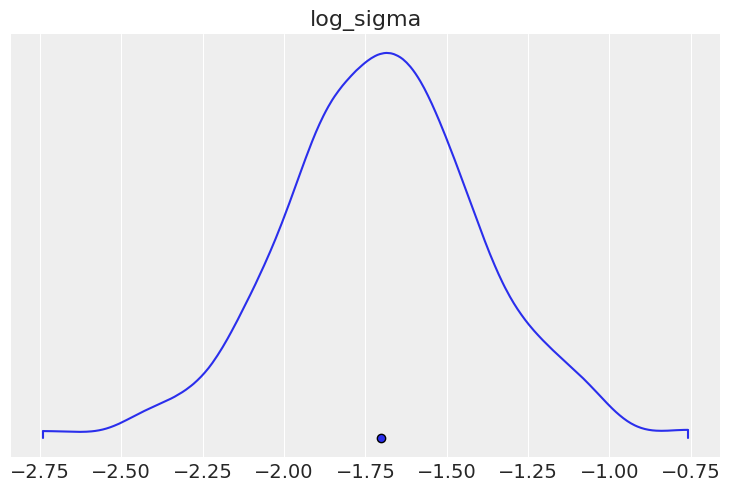